In [1]:
!pip install pennylane-lightning[gpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 9.3 MB/s eta 0:00:00


In [2]:
import pennylane as qml
import pennylane.numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Load and preprocess data
data = load_breast_cancer()
X = data.data[:, :25]
y = data.target


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = normalize(scaler.fit_transform(X_train), norm='l2')
X_test = normalize(scaler.transform(X_test), norm='l2')

X_train_aug = X_train + np.random.normal(0, 0.01, X_train.shape)
X_train = np.vstack([X_train, X_train_aug])
y_train = np.hstack([y_train, y_train])


In [4]:

def pca(X, num_components=5):
    rho = sum(np.outer(x, x) for x in X) / len(X)
    eigvals, eigvecs = np.linalg.eigh(rho)
    top_indices = np.argsort(eigvals)[-num_components:]
    top_vectors = eigvecs[:, top_indices]
    return X @ top_vectors

X_train = pca(X_train, 5)
X_test = pca(X_test, 5)



In [5]:
dev = qml.device("lightning.qubit", wires=5)

def variational_block(x, weights):
    for i in range(5):
        qml.RY(x[i], wires=i)
        qml.RZ(x[i] ** 2, wires=i)
    for i in range(5):
        qml.RY(weights[i], wires=i)
    for i in range(4):
        qml.CNOT(wires=[i, i + 1])
    qml.CNOT(wires=[4, 0])

@qml.qnode(dev)
def quantum_node(x, weights):
    variational_block(x, weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(5)]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def hybrid_model(x, params):
    q_out = np.array(quantum_node(x, params[:5]), requires_grad=True)
    hidden = leaky_relu(np.dot(params[5:10], q_out) + params[10])
    output = leaky_relu(np.dot(params[11:16], hidden) + params[16])
    final = sigmoid(np.dot(params[17:22], output) + params[22])
    return final

def weighted_bce(preds, labels, pos_weight):
    return -np.mean(pos_weight * labels * np.log(preds + 1e-6) +
                    (1 - labels) * np.log(1 - preds + 1e-6))

class_weights = np.array([1.0, len(y_train) / (2 * np.bincount(y_train)[1])])

def cost(params, X, y):
    preds = np.array([hybrid_model(x, params) for x in X], requires_grad=True)
    bce = weighted_bce(preds, y, pos_weight=class_weights[1])
    reg = 0.001 * np.sum(params ** 2)
    return bce + reg

def compute_metrics(params, X, y):
    preds = [hybrid_model(x, params) > 0.5 for x in X]
    acc = accuracy_score(y, preds)
    prec = precision_score(y, preds, zero_division=0)
    rec = recall_score(y, preds, zero_division=0)
    f1 = f1_score(y, preds, zero_division=0)
    return acc, prec, rec, f1
    


In [6]:
np.random.seed(42)
params = np.random.uniform(-0.1, 0.1, 23, requires_grad=True)
opt = qml.AdamOptimizer(0.01)
epochs = 101

train_losses = []
test_losses = []
train_accs = []
test_accs = []
best_acc = 0
best_epo = 0
best_param = []
for epoch in range(epochs):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)
    
    train_loss = cost(params, X_train, y_train)
    test_loss = cost(params, X_test, y_test)
    
    # Compute metrics for train and test sets
    train_acc, train_prec, train_rec, train_f1 = compute_metrics(params, X_train, y_train)
    test_acc, test_prec, test_rec, test_f1 = compute_metrics(params, X_test, y_test)

    # Store metrics
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    # Track best test accuracy
    if test_acc > best_acc:
        best_acc = test_acc
        best_epo = epoch
        best_params = params.copy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {train_loss:.4f}")
        print(f"Train - Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")
        print(f"Test  - Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")



Epoch 0 | Loss: 0.6077
Train - Acc: 0.3736, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Test  - Acc: 0.3684, Prec: 0.0000, Rec: 0.0000, F1: 0.0000
Epoch 10 | Loss: 0.6018
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 20 | Loss: 0.5975
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 30 | Loss: 0.5968
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 40 | Loss: 0.5956
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 50 | Loss: 0.5879
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 60 | Loss: 0.5494
Train - Acc: 0.6264, Prec: 0.6264, Rec: 1.0000, F1: 0.7703
Test  - Acc: 0.6316, Prec: 0.6316, Rec: 1.0000, F1: 0.7742
Epoch 7

In [7]:
# Final evaluation with best parameters
print("\nFinal Results with Best Parameters (Epoch {}):".format(best_epo))
train_acc, train_prec, train_rec, train_f1 = compute_metrics(best_params, X_train, y_train)
test_acc, test_prec, test_rec, test_f1 = compute_metrics(best_params, X_test, y_test)
print(f"Train - Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, Rec: {train_rec:.4f}, F1: {train_f1:.4f}")
print(f"Test  - Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}, F1: {test_f1:.4f}")


Final Results with Best Parameters (Epoch 90):
Train - Acc: 0.9407, Prec: 0.9135, Rec: 1.0000, F1: 0.9548
Test  - Acc: 0.9649, Prec: 0.9474, Rec: 1.0000, F1: 0.9730


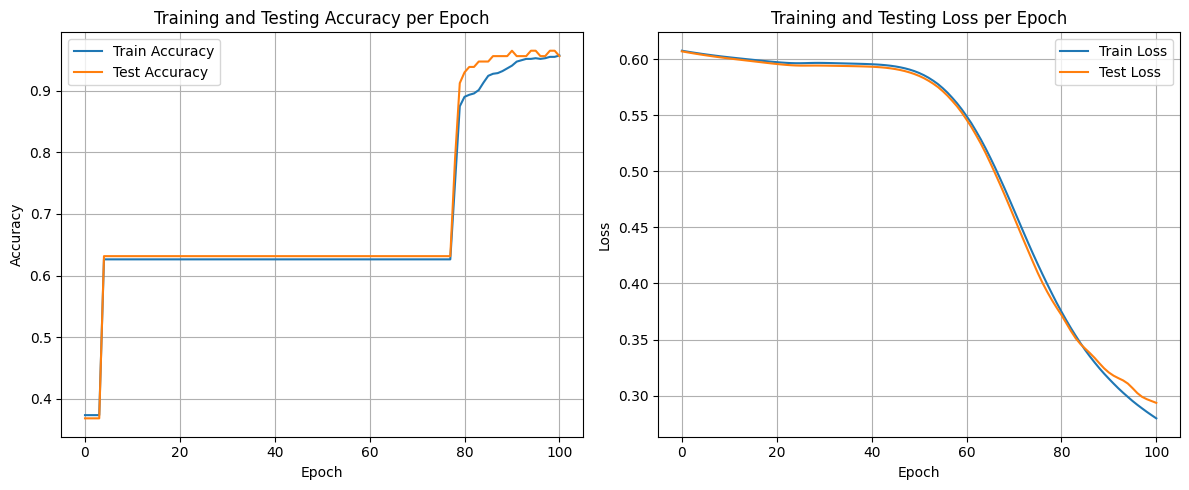

In [8]:
# Plotting accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accs, label='Train Accuracy')
plt.plot(range(epochs), test_accs, label='Test Accuracy')
plt.title('Training and Testing Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.title('Training and Testing Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')


In [9]:
import csv

csv_file = '/kaggle/working/5qubit_withPCA.csv'

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # header
    writer.writerow(['epoch', 'train_acc', 'test_acc', 'train_loss', 'test_loss'])

    for epoch in range(len(train_accs)):
        writer.writerow([
            epoch + 1,
            train_accs[epoch],
            test_accs[epoch],
            train_losses[epoch],
            test_losses[epoch]
        ])


Epoch   0 | Loss 0.6076
 Train: acc 0.374 prec 0.000 rec 0.000 f1 0.000
 Test : acc 0.368 prec 0.000 rec 0.000 f1 0.000

Epoch  10 | Loss 0.5627
 Train: acc 0.626 prec 0.626 rec 1.000 f1 0.770
 Test : acc 0.632 prec 0.632 rec 1.000 f1 0.774

Epoch  20 | Loss 0.3836
 Train: acc 0.782 prec 0.742 rec 1.000 f1 0.852
 Test : acc 0.833 prec 0.791 rec 1.000 f1 0.883

Epoch  30 | Loss 0.3439
 Train: acc 0.912 prec 0.902 rec 0.965 f1 0.932
 Test : acc 0.912 prec 0.908 rec 0.958 f1 0.932

Epoch  40 | Loss 0.2632
 Train: acc 0.923 prec 0.911 rec 0.972 f1 0.941
 Test : acc 0.886 prec 0.883 rec 0.944 f1 0.913

Epoch  50 | Loss 0.2139
 Train: acc 0.923 prec 0.908 rec 0.975 f1 0.941
 Test : acc 0.860 prec 0.878 rec 0.903 f1 0.890

Epoch  60 | Loss 0.1811
 Train: acc 0.930 prec 0.917 rec 0.975 f1 0.946
 Test : acc 0.877 prec 0.882 rec 0.931 f1 0.905

Epoch  70 | Loss 0.1580
 Train: acc 0.930 prec 0.917 rec 0.975 f1 0.946
 Test : acc 0.877 prec 0.892 rec 0.917 f1 0.904

Epoch  80 | Loss 0.1469
 Train: 

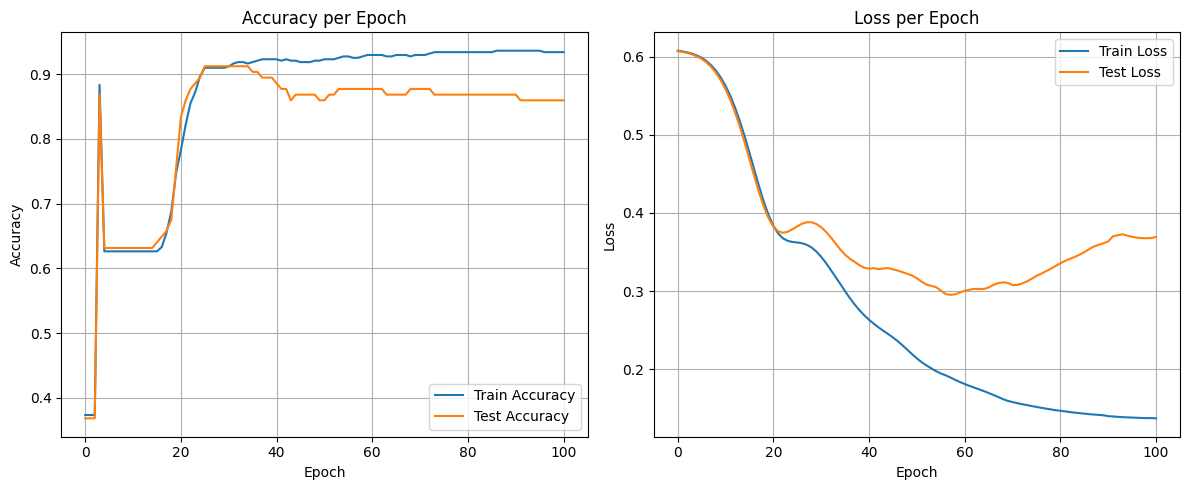

In [10]:
# -----------------------------------------------------------
# Classical counterpart to the hybrid quantum model
# -----------------------------------------------------------
import pennylane as qml                   # optimiser only
from pennylane import numpy as np         # autograd-compatible NumPy
import numpy as npa                       # plain NumPy for PCA math
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score)

# ---------- 1.  DATA ----------
data = load_breast_cancer()
X_full = data.data
y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# ---------- 2.  PCA to 5 dims (same size as 5 qubits) ----------
def pca(X, num_components=5):
    Xc = X - X.mean(axis=0)
    rho = (Xc.T @ Xc) / len(X)            # covariance
    eigvals, eigvecs = npa.linalg.eigh(rho)
    top_idx = npa.argsort(eigvals)[-num_components:]
    top_vecs = eigvecs[:, top_idx]
    return Xc @ top_vecs                  # shape (n_samples, num_components)

X_train = pca(X_train, 5)
X_test  = pca(X_test, 5)

# convert to autograd-friendly arrays
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

# ---------- 3.  Activation functions ----------
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

# ---------- 4.  Classical-only network (23 params) ----------
def classical_model(x, params):
    # layer-0: element-wise scaling (5 params)
    z0 = x * params[0:5]                       # (5,)

    # layer-1: scalar hidden
    h1 = leaky_relu(np.dot(params[5:10], z0) + params[10])

    # layer-2: scalar hidden
    h2 = leaky_relu(np.dot(params[11:16], h1) + params[16])

    # output: sigmoid
    out = sigmoid(np.dot(params[17:22], h2) + params[22])
    return out                                 # scalar in (0,1)

# ---------- 5.  Loss & metrics ----------
def weighted_bce(preds, labels, pos_weight):
    return -np.mean(pos_weight * labels * np.log(preds + 1e-6) +
                    (1 - labels) * np.log(1 - preds + 1e-6))

# class imbalance weight (same rule you used)
class_weights = np.array([1.0, len(y_train) / (2 * np.bincount(y_train)[1])])

def cost(params, X, y):
    preds = np.array([classical_model(x, params) for x in X], requires_grad=True)
    bce   = weighted_bce(preds, y, pos_weight=class_weights[1])
    reg   = 0.001 * np.sum(params ** 2)
    return bce + reg

def compute_metrics(params, X, y):
    preds_cls = [classical_model(x, params) > 0.5 for x in X]
    acc  = accuracy_score(y, preds_cls)
    prec = precision_score(y, preds_cls, zero_division=0)
    rec  = recall_score(y, preds_cls, zero_division=0)
    f1   = f1_score(y, preds_cls, zero_division=0)
    return acc, prec, rec, f1

# ---------- 6.  Training loop ----------
np.random.seed(42)
params = np.random.uniform(-0.1, 0.1, 23, requires_grad=True)
opt    = qml.AdamOptimizer(0.01)
epochs = 101

train_losses, test_losses = [], []
train_accs,  test_accs   = [], []
best_acc = 0
best_epoch = 0
best_params = params.copy()

for epoch in range(epochs):
    params = opt.step(lambda p: cost(p, X_train, y_train), params)

    train_loss = cost(params, X_train, y_train)
    test_loss  = cost(params, X_test,  y_test)

    tr_acc, tr_prec, tr_rec, tr_f1 = compute_metrics(params, X_train, y_train)
    te_acc, te_prec, te_rec, te_f1 = compute_metrics(params, X_test,  y_test)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(tr_acc)
    test_accs.append(te_acc)

    if te_acc > best_acc:
        best_acc    = te_acc
        best_epoch  = epoch
        best_params = params.copy()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} | Loss {train_loss:.4f}")
        print(f" Train: acc {tr_acc:.3f} prec {tr_prec:.3f} rec {tr_rec:.3f} f1 {tr_f1:.3f}")
        print(f" Test : acc {te_acc:.3f} prec {te_prec:.3f} rec {te_rec:.3f} f1 {te_f1:.3f}\n")

# ---------- 7.  Final metrics ----------
final_acc, final_prec, final_rec, final_f1 = compute_metrics(best_params, X_test, y_test)
print("Best epoch :", best_epoch)
print(f"Test metrics @best  ->  Acc {final_acc:.3f}  Prec {final_prec:.3f}  "
      f"Rec {final_rec:.3f}  F1 {final_f1:.3f}")

# ---------- 8.  Plotting ----------
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accs, label='Train Accuracy')
plt.plot(range(epochs), test_accs,  label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses,  label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('results_classicalNN.png')   # find it in Kaggle's "Output" tab
plt.show()


In [11]:
# ── Export classical-model metrics to CSV ─────────────────────────────────
import csv
import os

csv_file = '/kaggle/working/metrics_classicalNN.csv'

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['epoch', 'train_acc', 'test_acc', 'train_loss', 'test_loss'])
    
    for epoch, (tr_a, te_a, tr_l, te_l) in enumerate(
            zip(train_accs, test_accs, train_losses, test_losses), start=1):
        writer.writerow([epoch, tr_a, te_a, tr_l, te_l])

print(f"✓ Metrics written to {csv_file}")


✓ Metrics written to /kaggle/working/metrics_classicalNN.csv


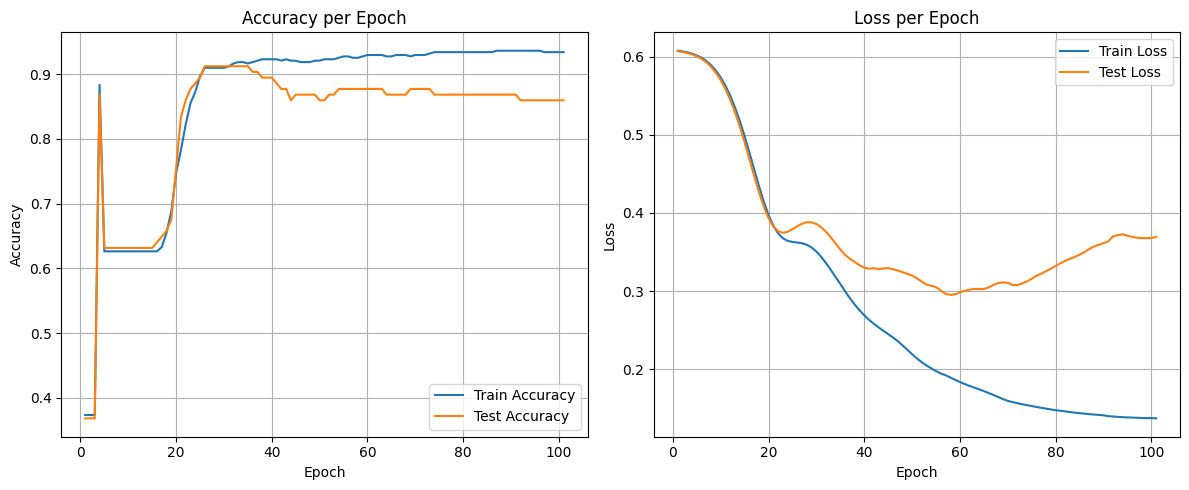

✓ Plot saved to /kaggle/working/metrics_classicalNN.png


In [12]:
# ── Plot & save accuracy / loss curves ───────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_accs) + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, len(test_accs) + 1),  test_accs,  label='Test Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1),  test_losses,  label='Test Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_file = '/kaggle/working/metrics_classicalNN.png'
plt.savefig(plot_file, dpi=300)
plt.show()

print(f"✓ Plot saved to {plot_file}")
